# Palm Detector Tutorial
# Deploying the Palm Detector with Vitis-AI for DPU inference

## Goal

In this notebook we show how to deploy the BlazePalm model (a PyTorch version of the mediapipe hand-gesture)
with Vitis-AI for deployment on the DPU. We will cover:

* Create the PyTorch model and load pre-trained weights
* Quantizing and evaluating the PyTorch model
* Compiling for DPU using the Vitis AI compiler


## References

* [BlazeFace-PyTorch](https://github.com/hollance/BlazeFace-PyTorch)
* [MediaPipePytorch](https://github.com/zmurez/MediaPipePyTorch)
* [Vitis AI v3.5](https://github.com/Xilinx/Vitis-AI/tree/v3.5)
   * [vai_q_pytorch](https://docs.xilinx.com/r/en-US/ug1414-vitis-ai/Running-vai_q_pytorch)
   * [vai_c_xir](https://docs.xilinx.com/r/en-US/ug1414-vitis-ai/Compiling-for-DPU)
* [DPU-PYNQ](https://github.com/Xilinx/DPU-PYNQ)


## Version History
* Jan 4, 2024
    * Preliminary revision

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

print(torch.__version__)

1.13.1


In [2]:
# use GPU if available   
if (torch.cuda.device_count() > 0):
  print('You have',torch.cuda.device_count(),'CUDA devices available')
  for i in range(torch.cuda.device_count()):
    print(' Device',str(i),': ',torch.cuda.get_device_name(i))
  print('Selecting device 0..')
  device = torch.device('cuda:0')
else:
  print('No CUDA devices available..selecting CPU')
  device = torch.device('cpu')

# load trained model
#model = CNN().to(device)
#model.load_state_dict(torch.load(os.path.join(float_model,'f_model.pth')))

No CUDA devices available..selecting CPU


# 1. Model Definition

Following sections copied from the MediaPipePyTorch repository

# Visualization
../MediaPipePytorch/visualization.py

In [3]:
def draw_detections(img, detections, with_keypoints=True):
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    n_keypoints = detections.shape[1] // 2 - 2

    for i in range(detections.shape[0]):
        ymin = detections[i, 0]
        xmin = detections[i, 1]
        ymax = detections[i, 2]
        xmax = detections[i, 3]
        
        start_point = (int(xmin), int(ymin))
        end_point = (int(xmax), int(ymax))
        img = cv2.rectangle(img, start_point, end_point, (255, 0, 0), 1) 

        if with_keypoints:
            for k in range(n_keypoints):
                kp_x = int(detections[i, 4 + k*2    ])
                kp_y = int(detections[i, 4 + k*2 + 1])
                cv2.circle(img, (kp_x, kp_y), 2, (0, 0, 255), thickness=2)
    return img


def draw_roi(img, roi):
    for i in range(roi.shape[0]):
        (x1,x2,x3,x4), (y1,y2,y3,y4) = roi[i]
        cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,0), 2)
        cv2.line(img, (int(x1), int(y1)), (int(x3), int(y3)), (0,255,0), 2)
        cv2.line(img, (int(x2), int(y2)), (int(x4), int(y4)), (0,0,0), 2)
        cv2.line(img, (int(x3), int(y3)), (int(x4), int(y4)), (0,0,0), 2)


def draw_landmarks(img, points, connections=[], color=(0, 255, 0), size=2):
    points = points[:,:2]
    for point in points:
        x, y = point
        x, y = int(x), int(y)
        cv2.circle(img, (x, y), size, color, thickness=size)
    for connection in connections:
        x0, y0 = points[connection[0]]
        x1, y1 = points[connection[1]]
        x0, y0 = int(x0), int(y0)
        x1, y1 = int(x1), int(y1)
        cv2.line(img, (x0, y0), (x1, y1), (0,0,0), size)



# https://github.com/metalwhale/hand_tracking/blob/b2a650d61b4ab917a2367a05b85765b81c0564f2/run.py
#        8   12  16  20
#        |   |   |   |
#        7   11  15  19
#    4   |   |   |   |
#    |   6   10  14  18
#    3   |   |   |   |
#    |   5---9---13--17
#    2    \         /
#     \    \       /
#      1    \     /
#       \    \   /
#        ------0-
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (5, 6), (6, 7), (7, 8),
    (9, 10), (10, 11), (11, 12),
    (13, 14), (14, 15), (15, 16),
    (17, 18), (18, 19), (19, 20),
    (0, 5), (5, 9), (9, 13), (13, 17), (0, 17)
]

POSE_CONNECTIONS = [
    (0,1), (1,2), (2,3), (3,7),
    (0,4), (4,5), (5,6), (6,8),
    (9,10),
    (11,13), (13,15), (15,17), (17,19), (19,15), (15,21),
    (12,14), (14,16), (16,18), (18,20), (20,16), (16,22),
    (11,12), (12,24), (24,23), (23,11)
]

# Vertex indices can be found in
# github.com/google/mediapipe/modules/face_geometry/data/canonical_face_model_uv_visualisation.png
# Found in github.com/google/mediapipe/python/solutions/face_mesh.py
FACE_CONNECTIONS = [
    # Lips.
    (61, 146), (146, 91), (91, 181), (181, 84), (84, 17),
    (17, 314), (314, 405), (405, 321), (321, 375), (375, 291),
    (61, 185), (185, 40), (40, 39), (39, 37), (37, 0),
    (0, 267), (267, 269), (269, 270), (270, 409), (409, 291),
    (78, 95), (95, 88), (88, 178), (178, 87), (87, 14),
    (14, 317), (317, 402), (402, 318), (318, 324), (324, 308),
    (78, 191), (191, 80), (80, 81), (81, 82), (82, 13),
    (13, 312), (312, 311), (311, 310), (310, 415), (415, 308),
    # Left eye.
    (263, 249), (249, 390), (390, 373), (373, 374), (374, 380),
    (380, 381), (381, 382), (382, 362), (263, 466), (466, 388),
    (388, 387), (387, 386), (386, 385), (385, 384), (384, 398),
    (398, 362),
    # Left eyebrow.
    (276, 283), (283, 282), (282, 295), (295, 285), (300, 293),
    (293, 334), (334, 296), (296, 336),
    # Right eye.
    (33, 7), (7, 163), (163, 144), (144, 145), (145, 153),
    (153, 154), (154, 155), (155, 133), (33, 246), (246, 161),
    (161, 160), (160, 159), (159, 158), (158, 157), (157, 173),
    (173, 133),
    # Right eyebrow.
    (46, 53), (53, 52), (52, 65), (65, 55), (70, 63), (63, 105),
    (105, 66), (66, 107),
    # Face oval.
    (10, 338), (338, 297), (297, 332), (332, 284), (284, 251),
    (251, 389), (389, 356), (356, 454), (454, 323), (323, 361),
    (361, 288), (288, 397), (397, 365), (365, 379), (379, 378),
    (378, 400), (400, 377), (377, 152), (152, 148), (148, 176),
    (176, 149), (149, 150), (150, 136), (136, 172), (172, 58),
    (58, 132), (132, 93), (93, 234), (234, 127), (127, 162),
    (162, 21), (21, 54), (54, 103), (103, 67), (67, 109),
    (109, 10)
]

## Blaze Base
../MediaPipePytorch/blazebase.py

In [4]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def resize_pad(img):
    """ resize and pad images to be input to the detectors

    The face and palm detector networks take 256x256 and 128x128 images
    as input. As such the input image is padded and resized to fit the
    size while maintaing the aspect ratio.

    Returns:
        img1: 256x256
        img2: 128x128
        scale: scale factor between original image and 256x256 image
        pad: pixels of padding in the original image
    """

    size0 = img.shape
    if size0[0]>=size0[1]:
        h1 = 256
        w1 = 256 * size0[1] // size0[0]
        padh = 0
        padw = 256 - w1
        scale = size0[1] / w1
    else:
        h1 = 256 * size0[0] // size0[1]
        w1 = 256
        padh = 256 - h1
        padw = 0
        scale = size0[0] / h1
    padh1 = padh//2
    padh2 = padh//2 + padh%2
    padw1 = padw//2
    padw2 = padw//2 + padw%2
    img1 = cv2.resize(img, (w1,h1))
    img1 = np.pad(img1, ((padh1, padh2), (padw1, padw2), (0,0)))
    pad = (int(padh1 * scale), int(padw1 * scale))
    img2 = cv2.resize(img1, (128,128))
    return img1, img2, scale, pad


def denormalize_detections(detections, scale, pad):
    """ maps detection coordinates from [0,1] to image coordinates

    The face and palm detector networks take 256x256 and 128x128 images
    as input. As such the input image is padded and resized to fit the
    size while maintaing the aspect ratio. This function maps the
    normalized coordinates back to the original image coordinates.

    Inputs:
        detections: nxm tensor. n is the number of detections.
            m is 4+2*k where the first 4 valuse are the bounding
            box coordinates and k is the number of additional
            keypoints output by the detector.
        scale: scalar that was used to resize the image
        pad: padding in the x and y dimensions

    """
    detections[:, 0] = detections[:, 0] * scale * 256 - pad[0]
    detections[:, 1] = detections[:, 1] * scale * 256 - pad[1]
    detections[:, 2] = detections[:, 2] * scale * 256 - pad[0]
    detections[:, 3] = detections[:, 3] * scale * 256 - pad[1]

    detections[:, 4::2] = detections[:, 4::2] * scale * 256 - pad[1]
    detections[:, 5::2] = detections[:, 5::2] * scale * 256 - pad[0]
    return detections




class BlazeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act='relu', skip_proj=False):
        super(BlazeBlock, self).__init__()

        self.stride = stride
        self.kernel_size = kernel_size
        self.channel_pad = out_channels - in_channels

        # TFLite uses slightly different padding than PyTorch 
        # on the depthwise conv layer when the stride is 2.
        if stride == 2:
            self.max_pool = nn.MaxPool2d(kernel_size=stride, stride=stride)
            padding = 0
        else:
            padding = (kernel_size - 1) // 2

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, 
                      kernel_size=kernel_size, stride=stride, padding=padding, 
                      groups=in_channels, bias=True),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=1, stride=1, padding=0, bias=True),
        )

        if skip_proj:
            self.skip_proj = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                      kernel_size=1, stride=1, padding=0, bias=True)
        else:
            self.skip_proj = None

        if act == 'relu':
            self.act = nn.ReLU(inplace=True)
        elif act == 'prelu':
            self.act = nn.PReLU(out_channels)
        else:
            raise NotImplementedError("unknown activation %s"%act)

    def forward(self, x):
        if self.stride == 2:
            if self.kernel_size==3:
                h = F.pad(x, (0, 2, 0, 2), "constant", 0)
            else:
                h = F.pad(x, (1, 2, 1, 2), "constant", 0)
            x = self.max_pool(x)
        else:
            h = x

        if self.skip_proj is not None:
            x = self.skip_proj(x)
        elif self.channel_pad > 0:
            #print("[BlazeBlock] before pad : x.shape=",x.shape," x.dtype=",x.dtype," x=",x)
            #print("[BlazeBlock] stride=",self.stride," kernel_size=",self.kernel_size," channel_pad=",self.channel_pad)
            # create another tensor in the “missing” shape and use torch.cat((x, other), dim=6) to concatenate them
            x_padding = torch.empty(x.shape[0],x.shape[1],x.shape[2],x.shape[3]).fill_(0.)
            #print("[BlazeBlock] testing : x_padding.shape=",x_padding.shape," x_padding.dtype=",x_padding.dtype," x_padding=",x_padding)
            x_padded  = torch.cat((x,x_padding),dim=1)
            #print("[BlazeBlock] testing : x_padded.shape=",x_padded.shape," x_padded.dtype=",x_padding.dtype," x_padded=",x_padded)
            #x = F.pad(x, (0, 0, 0, 0, 0, self.channel_pad), "constant", 0)
            x = x_padded
            #print("[BlazeBlock] after pad : x.shape=",x.shape," x.dtype=",x.dtype," x=",x)
            
        

        return self.act(self.convs(h) + x)


class FinalBlazeBlock(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(FinalBlazeBlock, self).__init__()

        # TFLite uses slightly different padding than PyTorch
        # on the depthwise conv layer when the stride is 2.
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=channels, out_channels=channels,
                      kernel_size=kernel_size, stride=2, padding=0,
                      groups=channels, bias=True),
            nn.Conv2d(in_channels=channels, out_channels=channels,
                      kernel_size=1, stride=1, padding=0, bias=True),
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        h = F.pad(x, (0, 2, 0, 2), "constant", 0)

        return self.act(self.convs(h))


class BlazeBase(nn.Module):
    """ Base class for media pipe models. """

    def _device(self):
        """Which device (CPU or GPU) is being used by this model?"""
        return self.classifier_8.weight.device
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()        


class BlazeLandmark(BlazeBase):
    """ Base class for landmark models. """

    def extract_roi(self, frame, xc, yc, theta, scale):

        # take points on unit square and transform them according to the roi
        points = torch.tensor([[-1, -1, 1, 1],
                            [-1, 1, -1, 1]], device=scale.device).view(1,2,4)
        points = points * scale.view(-1,1,1)/2
        theta = theta.view(-1, 1, 1)
        R = torch.cat((
            torch.cat((torch.cos(theta), -torch.sin(theta)), 2),
            torch.cat((torch.sin(theta), torch.cos(theta)), 2),
            ), 1)
        center = torch.cat((xc.view(-1,1,1), yc.view(-1,1,1)), 1)
        points = R @ points + center

        # use the points to compute the affine transform that maps 
        # these points back to the output square
        res = self.resolution
        points1 = np.array([[0, 0, res-1],
                            [0, res-1, 0]], dtype=np.float32).T
        affines = []
        imgs = []
        for i in range(points.shape[0]):
            pts = points[i, :, :3].cpu().numpy().T
            M = cv2.getAffineTransform(pts, points1)
            img = cv2.warpAffine(frame, M, (res,res))#, borderValue=127.5)
            img = torch.tensor(img, device=scale.device)
            imgs.append(img)
            affine = cv2.invertAffineTransform(M).astype('float32')
            affine = torch.tensor(affine, device=scale.device)
            affines.append(affine)
        if imgs:
            imgs = torch.stack(imgs).permute(0,3,1,2).float() / 255.#/ 127.5 - 1.0
            affines = torch.stack(affines)
        else:
            imgs = torch.zeros((0, 3, res, res), device=scale.device)
            affines = torch.zeros((0, 2, 3), device=scale.device)

        return imgs, affines, points

    def denormalize_landmarks(self, landmarks, affines):
        landmarks[:,:,:2] *= self.resolution
        for i in range(len(landmarks)):
            landmark, affine = landmarks[i], affines[i]
            landmark = (affine[:,:2] @ landmark[:,:2].T + affine[:,2:]).T
            landmarks[i,:,:2] = landmark
        return landmarks



class BlazeDetector(BlazeBase):
    """ Base class for detector models.

    Based on code from https://github.com/tkat0/PyTorch_BlazeFace/ and
    https://github.com/hollance/BlazeFace-PyTorch and
    https://github.com/google/mediapipe/
    """
    def load_anchors(self, path):
        self.anchors = torch.tensor(np.load(path), dtype=torch.float32, device=self._device())
        assert(self.anchors.ndimension() == 2)
        assert(self.anchors.shape[0] == self.num_anchors)
        assert(self.anchors.shape[1] == 4)

    def _preprocess(self, x):
        """Converts the image pixels to the range [-1, 1]."""
        return x.float() / 255.# 127.5 - 1.0

    def predict_on_image(self, img):
        """Makes a prediction on a single image.

        Arguments:
            img: a NumPy array of shape (H, W, 3) or a PyTorch tensor of
                 shape (3, H, W). The image's height and width should be 
                 128 pixels.

        Returns:
            A tensor with face detections.
        """
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).permute((2, 0, 1))

        return self.predict_on_batch(img.unsqueeze(0))[0]

    def predict_on_batch(self, x):
        """Makes a prediction on a batch of images.

        Arguments:
            x: a NumPy array of shape (b, H, W, 3) or a PyTorch tensor of
               shape (b, 3, H, W). The height and width should be 128 pixels.

        Returns:
            A list containing a tensor of face detections for each image in 
            the batch. If no faces are found for an image, returns a tensor
            of shape (0, 17).

        Each face detection is a PyTorch tensor consisting of 17 numbers:
            - ymin, xmin, ymax, xmax
            - x,y-coordinates for the 6 keypoints
            - confidence score
        """
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).permute((0, 3, 1, 2))

        assert x.shape[1] == 3
        assert x.shape[2] == self.y_scale
        assert x.shape[3] == self.x_scale

        # 1. Preprocess the images into tensors:
        x = x.to(self._device())
        x = self._preprocess(x)

        # 2. Run the neural network:
        with torch.no_grad():
            out = self.__call__(x)

        # 3. Postprocess the raw predictions:
        detections = self._tensors_to_detections(out[0], out[1], self.anchors)

        # 4. Non-maximum suppression to remove overlapping detections:
        filtered_detections = []
        for i in range(len(detections)):
            faces = self._weighted_non_max_suppression(detections[i])
            faces = torch.stack(faces) if len(faces) > 0 else torch.zeros((0, self.num_coords+1))
            filtered_detections.append(faces)

        return filtered_detections


    def detection2roi(self, detection):
        """ Convert detections from detector to an oriented bounding box.

        Adapted from:
        # mediapipe/modules/face_landmark/face_detection_front_detection_to_roi.pbtxt

        The center and size of the box is calculated from the center 
        of the detected box. Rotation is calcualted from the vector
        between kp1 and kp2 relative to theta0. The box is scaled
        and shifted by dscale and dy.

        """
        if self.detection2roi_method == 'box':
            # compute box center and scale
            # use mediapipe/calculators/util/detections_to_rects_calculator.cc
            xc = (detection[:,1] + detection[:,3]) / 2
            yc = (detection[:,0] + detection[:,2]) / 2
            scale = (detection[:,3] - detection[:,1]) # assumes square boxes

        elif self.detection2roi_method == 'alignment':
            # compute box center and scale
            # use mediapipe/calculators/util/alignment_points_to_rects_calculator.cc
            xc = detection[:,4+2*self.kp1]
            yc = detection[:,4+2*self.kp1+1]
            x1 = detection[:,4+2*self.kp2]
            y1 = detection[:,4+2*self.kp2+1]
            scale = ((xc-x1)**2 + (yc-y1)**2).sqrt() * 2
        else:
            raise NotImplementedError(
                "detection2roi_method [%s] not supported"%self.detection2roi_method)

        yc += self.dy * scale
        scale *= self.dscale

        # compute box rotation
        x0 = detection[:,4+2*self.kp1]
        y0 = detection[:,4+2*self.kp1+1]
        x1 = detection[:,4+2*self.kp2]
        y1 = detection[:,4+2*self.kp2+1]
        #theta = np.arctan2(y0-y1, x0-x1) - self.theta0
        theta = torch.atan2(y0-y1, x0-x1) - self.theta0
        return xc, yc, scale, theta


    def _tensors_to_detections(self, raw_box_tensor, raw_score_tensor, anchors):
        """The output of the neural network is a tensor of shape (b, 896, 16)
        containing the bounding box regressor predictions, as well as a tensor 
        of shape (b, 896, 1) with the classification confidences.

        This function converts these two "raw" tensors into proper detections.
        Returns a list of (num_detections, 17) tensors, one for each image in
        the batch.

        This is based on the source code from:
        mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.cc
        mediapipe/calculators/tflite/tflite_tensors_to_detections_calculator.proto
        """
        assert raw_box_tensor.ndimension() == 3
        assert raw_box_tensor.shape[1] == self.num_anchors
        assert raw_box_tensor.shape[2] == self.num_coords

        assert raw_score_tensor.ndimension() == 3
        assert raw_score_tensor.shape[1] == self.num_anchors
        assert raw_score_tensor.shape[2] == self.num_classes

        assert raw_box_tensor.shape[0] == raw_score_tensor.shape[0]
        
        detection_boxes = self._decode_boxes(raw_box_tensor, anchors)
        
        thresh = self.score_clipping_thresh
        raw_score_tensor = raw_score_tensor.clamp(-thresh, thresh)
        detection_scores = raw_score_tensor.sigmoid().squeeze(dim=-1)
        
        # Note: we stripped off the last dimension from the scores tensor
        # because there is only has one class. Now we can simply use a mask
        # to filter out the boxes with too low confidence.
        mask = detection_scores >= self.min_score_thresh

        # Because each image from the batch can have a different number of
        # detections, process them one at a time using a loop.
        output_detections = []
        for i in range(raw_box_tensor.shape[0]):
            boxes = detection_boxes[i, mask[i]]
            scores = detection_scores[i, mask[i]].unsqueeze(dim=-1)
            output_detections.append(torch.cat((boxes, scores), dim=-1))

        return output_detections

    def _decode_boxes(self, raw_boxes, anchors):
        """Converts the predictions into actual coordinates using
        the anchor boxes. Processes the entire batch at once.
        """
        boxes = torch.zeros_like(raw_boxes)

        x_center = raw_boxes[..., 0] / self.x_scale * anchors[:, 2] + anchors[:, 0]
        y_center = raw_boxes[..., 1] / self.y_scale * anchors[:, 3] + anchors[:, 1]

        w = raw_boxes[..., 2] / self.w_scale * anchors[:, 2]
        h = raw_boxes[..., 3] / self.h_scale * anchors[:, 3]

        boxes[..., 0] = y_center - h / 2.  # ymin
        boxes[..., 1] = x_center - w / 2.  # xmin
        boxes[..., 2] = y_center + h / 2.  # ymax
        boxes[..., 3] = x_center + w / 2.  # xmax

        for k in range(self.num_keypoints):
            offset = 4 + k*2
            keypoint_x = raw_boxes[..., offset    ] / self.x_scale * anchors[:, 2] + anchors[:, 0]
            keypoint_y = raw_boxes[..., offset + 1] / self.y_scale * anchors[:, 3] + anchors[:, 1]
            boxes[..., offset    ] = keypoint_x
            boxes[..., offset + 1] = keypoint_y

        return boxes

    def _weighted_non_max_suppression(self, detections):
        """The alternative NMS method as mentioned in the BlazeFace paper:

        "We replace the suppression algorithm with a blending strategy that
        estimates the regression parameters of a bounding box as a weighted
        mean between the overlapping predictions."

        The original MediaPipe code assigns the score of the most confident
        detection to the weighted detection, but we take the average score
        of the overlapping detections.

        The input detections should be a Tensor of shape (count, 17).

        Returns a list of PyTorch tensors, one for each detected face.
        
        This is based on the source code from:
        mediapipe/calculators/util/non_max_suppression_calculator.cc
        mediapipe/calculators/util/non_max_suppression_calculator.proto
        """
        if len(detections) == 0: return []

        output_detections = []

        # Sort the detections from highest to lowest score.
        remaining = torch.argsort(detections[:, self.num_coords], descending=True)

        while len(remaining) > 0:
            detection = detections[remaining[0]]

            # Compute the overlap between the first box and the other 
            # remaining boxes. (Note that the other_boxes also include
            # the first_box.)
            first_box = detection[:4]
            other_boxes = detections[remaining, :4]
            ious = overlap_similarity(first_box, other_boxes)

            # If two detections don't overlap enough, they are considered
            # to be from different faces.
            mask = ious > self.min_suppression_threshold
            overlapping = remaining[mask]
            remaining = remaining[~mask]

            # Take an average of the coordinates from the overlapping
            # detections, weighted by their confidence scores.
            weighted_detection = detection.clone()
            if len(overlapping) > 1:
                coordinates = detections[overlapping, :self.num_coords]
                scores = detections[overlapping, self.num_coords:self.num_coords+1]
                total_score = scores.sum()
                weighted = (coordinates * scores).sum(dim=0) / total_score
                weighted_detection[:self.num_coords] = weighted
                weighted_detection[self.num_coords] = total_score / len(overlapping)

            output_detections.append(weighted_detection)

        return output_detections    


# IOU code from https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py

def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def overlap_similarity(box, other_boxes):
    """Computes the IOU between a bounding box and set of other boxes."""
    return jaccard(box.unsqueeze(0), other_boxes).squeeze(0)

## Base Palm
../MediaPipePytorch/blazepalm.py

In [5]:
class BlazePalm(BlazeDetector):
    """The palm detection model from MediaPipe. """
    def __init__(self):
        super(BlazePalm, self).__init__()

        # These are the settings from the MediaPipe example graph
        # mediapipe/graphs/hand_tracking/subgraphs/hand_detection_gpu.pbtxt
        self.num_classes = 1
        self.num_anchors = 2944
        self.num_coords = 18
        self.score_clipping_thresh = 100.0
        self.x_scale = 256.0
        self.y_scale = 256.0
        self.h_scale = 256.0
        self.w_scale = 256.0
        self.min_score_thresh = 0.5
        self.min_suppression_threshold = 0.3
        self.num_keypoints = 7

        # These settings are for converting detections to ROIs which can then
        # be extracted and feed into the landmark network
        # use mediapipe/calculators/util/detections_to_rects_calculator.cc
        self.detection2roi_method = 'box'
        # mediapipe/graphs/hand_tracking/subgraphs/hand_detection_cpu.pbtxt
        self.kp1 = 0
        self.kp2 = 2
        self.theta0 = np.pi/2
        self.dscale = 2.6
        self.dy = -0.5

        self._define_layers()

    def _define_layers(self):
        self.backbone1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=0, bias=True),
            nn.ReLU(inplace=True),

            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            BlazeBlock(32, 32),
            
            BlazeBlock(32, 64, stride=2),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),
            BlazeBlock(64, 64),

            BlazeBlock(64, 128, stride=2),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),
            BlazeBlock(128, 128),

        )
        
        self.backbone2 = nn.Sequential(
            BlazeBlock(128, 256, stride=2),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
        )

        self.backbone3 = nn.Sequential(
            BlazeBlock(256, 256, stride=2),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
            BlazeBlock(256, 256),
        )

        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)
        self.blaze1 = BlazeBlock(256, 256)

        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)
        self.blaze2 = BlazeBlock(128, 128)

        self.classifier_32 = nn.Conv2d(128, 2, 1, bias=True)
        self.classifier_16 = nn.Conv2d(256, 2, 1, bias=True)
        self.classifier_8 = nn.Conv2d(256, 6, 1, bias=True)
        
        self.regressor_32 = nn.Conv2d(128, 36, 1, bias=True)
        self.regressor_16 = nn.Conv2d(256, 36, 1, bias=True)
        self.regressor_8 = nn.Conv2d(256, 108, 1, bias=True)
        
    def forward(self, x):
        b = x.shape[0]      # batch size, needed for reshaping later

        x = F.pad(x, (0, 1, 0, 1), "constant", 0)

        x = self.backbone1(x)           # (b, 128, 32, 32)        
        y = self.backbone2(x)           # (b, 256, 16, 16)
        z = self.backbone3(y)           # (b, 256, 8, 8)

        y = y + F.relu(self.conv_transpose1(z), True)
        y = self.blaze1(y)

        x = x + F.relu(self.conv_transpose2(y), True)
        x = self.blaze2(x)


        # Note: Because PyTorch is NCHW but TFLite is NHWC, we need to
        # permute the output from the conv layers before reshaping it.
        
        c1 = self.classifier_8(z)       # (b, 2, 16, 16)
        c1 = c1.permute(0, 2, 3, 1)     # (b, 16, 16, 2)
        c1 = c1.reshape(b, -1, 1)       # (b, 512, 1)

        c2 = self.classifier_16(y)      # (b, 6, 8, 8)
        c2 = c2.permute(0, 2, 3, 1)     # (b, 8, 8, 6)
        c2 = c2.reshape(b, -1, 1)       # (b, 384, 1)

        c3 = self.classifier_32(x)      # (b, 6, 8, 8)
        c3 = c3.permute(0, 2, 3, 1)     # (b, 8, 8, 6)
        c3 = c3.reshape(b, -1, 1)       # (b, 384, 1)

        c = torch.cat((c3, c2, c1), dim=1)  # (b, 896, 1)

        r1 = self.regressor_8(z)        # (b, 32, 16, 16)
        r1 = r1.permute(0, 2, 3, 1)     # (b, 16, 16, 32)
        r1 = r1.reshape(b, -1, 18)      # (b, 512, 16)

        r2 = self.regressor_16(y)       # (b, 96, 8, 8)
        r2 = r2.permute(0, 2, 3, 1)     # (b, 8, 8, 96)
        r2 = r2.reshape(b, -1, 18)      # (b, 384, 16)

        r3 = self.regressor_32(x)       # (b, 96, 8, 8)
        r3 = r3.permute(0, 2, 3, 1)     # (b, 8, 8, 96)
        r3 = r3.reshape(b, -1, 18)      # (b, 384, 16)

        r = torch.cat((r3, r2, r1), dim=1)  # (b, 896, 16)

        return [r, c]

## Model Instantiation
../MediaPipePytorch/demo.py

In [6]:
model = BlazePalm().to(device)
model.load_weights("../MediaPipePyTorch/blazepalm.pth")
model.load_anchors('../MediaPipePyTorch/anchors_palm.npy')
model.min_score_thresh = .75
model.eval()



BlazePalm(
  (backbone1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU(inplace=True)
    )
    (3): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU(inplace=True)
    )
    (4): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
        (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU(inplace=True)
    )
    (5): BlazeBlock(
      (convs): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3

In [7]:
#!ls ../captured-images
#!ls ../captured-images
#filename='../captured-images/frame0110_asl00.tif'
#filename='../captured-images/frame0139_asl01.tif'
#filename='../captured-images/frame0159_asl11.tif'
#filename='../captured-images/frame0177_asl17.tif'
#filename='../captured-images/frame0383_asl28.tif'
#filename='../captured-images/frame0655_asl26.tif'
#filename='../captured-images/frame6925_asl24.tif'

In [8]:
# reference : https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg
filename = "image.jpg"

(960, 640, 3)
(960, 640, 3)
(256, 256, 3) (128, 128, 3) 3.764705882352941 (0, 161)
tensor([[0.3588, 0.4746, 0.4727, 0.5885, 0.4763, 0.4096, 0.5855, 0.4512, 0.5854,
         0.4239, 0.5763, 0.3954, 0.5621, 0.3676, 0.4913, 0.4376, 0.5391, 0.4550,
         0.9329],
        [0.6386, 0.2940, 0.7795, 0.4349, 0.4366, 0.6933, 0.3082, 0.7176, 0.2980,
         0.6999, 0.2999, 0.6861, 0.3096, 0.6756, 0.4283, 0.7212, 0.3755, 0.7449,
         0.9343]])
tensor([[345.8439, 296.4436, 455.6025, 406.2023, 298.0013, 394.7128, 403.2542,
         434.8518, 403.2105, 408.5775, 394.4514, 381.0287, 380.7528, 354.2592,
         312.4621, 421.7779, 358.5232, 438.4831, 738.1191],
        [615.4766, 122.3282, 751.2795, 258.1312, 259.7410, 668.1640, 136.0480,
         691.6131, 126.2117, 674.5099, 127.9897, 661.2545, 137.4056, 651.1075,
         251.7362, 695.0305, 200.9328, 717.9488, 739.4069]])
tensor([351.3230, 190.2297]) tensor([345.8439, 615.4766])


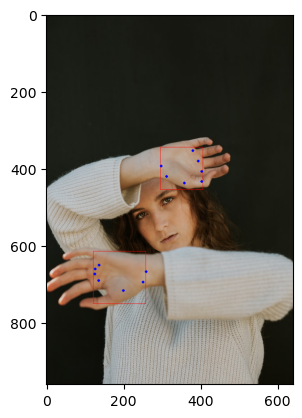

In [9]:
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

frame = cv2.imread(filename)
print(frame.shape)
frame = np.ascontiguousarray(frame[:,:,::-1])
print(frame.shape)
hh, ww, _ = frame.shape
ll = min(hh, ww)
#img = cv2.resize(frame[:ll, :ll][:, ::-1], (256, 256))
#img = cv2.resize(frame, (256, 256))
#print(img.shape)
#print(isinstance(img, np.ndarray))
img1, img2, scale, pad = resize_pad(frame)
print(img1.shape,img2.shape,scale,pad)
normalized_palm_detections = model.predict_on_image(img1)
print(normalized_palm_detections)
palm_detections = denormalize_detections(normalized_palm_detections, scale, pad)
print(palm_detections)

xc, yc, scale, theta = model.detection2roi(palm_detections.cpu())
print(xc,yc)

#draw_roi(frame, box2)
draw_detections(frame, palm_detections)


plt.imshow(frame)
plt.show()

## 2. Inspection
In order to determine if the model is supported by Vitis-AI, we start with the Vitis-AI Inspector.

In [10]:
from pytorch_nndct.apis import Inspector


[VAIQ_NOTE]: Loading NNDCT kernels...


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [11]:
inspector = Inspector("DPUCZDX8G_ISA1_B4096")
batchsize = 1
rand_in = torch.randn([batchsize, 3,256,256])
inspector.inspect(model, (rand_in), device=device)


[VAIQ_NOTE]: Inspector is on.

[VAIQ_NOTE]: =>Start to inspect model...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing BlazePalm...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_BlazePalm_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 225/225 [00:00<00:00, 906.69it/s, OpInfo: name = return_0, type = Return]                              



[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::empty` as a float operator by default.

[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::fill_` as a float operator by default.

[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(quantize_result/BlazePalm.py)

[VAIQ_WARN]: BlazePalm::13474 is not tensor.

[VAIQ_WARN]: BlazePalm::13859 is not tensor.

[VAIQ_WARN]: BlazePalm::13879 is not tensor.

[VAIQ_WARN]: BlazePalm::13899 is not tensor.

[VAIQ_WARN]: BlazePalm::13919 is not tensor.

[VAIQ_WARN]: BlazePalm::14317 is not tensor.

[VAIQ_WARN]: BlazePalm::14337 is not tensor.

[VAIQ_WARN]: BlazePalm::14357 is not tensor.

[VAIQ_WARN]: BlazePalm::14377 is not tensor.

[VAIQ_WARN]: BlazePalm::14775 is not tensor.

[VAIQ_WARN]: BlazePalm::14795 is not tensor.

[VAIQ_WARN]: BlazePalm::14815 is not tensor.

[VAIQ_WARN]: BlazePalm::14835 is not tensor.

[VAIQ_WARN]: Pad(BlazePalm::BlazePalm/ret.


[VAIQ_NOTE]: Find subgraph for eltwise_fix_23:
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[4]/ret.185, op type:nndct_elemwise_add, output shape: [1, 16, 16, 256]
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[4]/ReLU[act]/15074, op type:nndct_relu, output shape: [1, 16, 16, 256]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_23:
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[7]/ret.203, op type:nndct_elemwise_add, output shape: [1, 16, 16, 256]
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[7]/ReLU[act]/15206, op type:nndct_relu, output shape: [1, 16, 16, 256]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_23:
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[2]/ret.173, op type:nndct_elemwise_add, output shape: [1, 16, 16, 256]
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[2]/ReLU[act]/14986, op type:nndct_relu, output shape: [1, 16, 16, 256]



[VAIQ_NOTE]: Find subgraph for eltwise_

I20240108 08:06:34.388506  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:34.388530  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:34.388535  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:34.388592  2643 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv_transpose_2d_nndct_relu_jD4FGiHcZfaQd8SB, with op num: 9
I20240108 08:06:34.388597  2643 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240108 08:06:34.397382  2643 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240108 08:06:34.397413  2643 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240108 08:06:34.401938  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:34.401962  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:34.401964  


[VAIQ_NOTE]: Find subgraph for eltwise_fix_23:
node name:BlazePalm::BlazePalm/BlazeBlock[blaze1]/ret.263, op type:nndct_elemwise_add, output shape: [1, 16, 16, 256]
node name:BlazePalm::BlazePalm/BlazeBlock[blaze1]/ReLU[act]/15651, op type:nndct_relu, output shape: [1, 16, 16, 256]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_23:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[16]/ret.99, op type:nndct_elemwise_add, output shape: [1, 64, 64, 64]
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[16]/ReLU[act]/14290, op type:nndct_relu, output shape: [1, 64, 64, 64]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_23:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[18]/ret.115, op type:nndct_elemwise_add, output shape: [1, 32, 32, 128]
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[18]/ReLU[act]/14484, op type:nndct_relu, output shape: [1, 32, 32, 128]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_23:
node name:BlazePalm::Blaz

I20240108 08:06:34.596809  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:34.596813  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:34.596879  2643 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_elemwise_add_nndct_relu_BHALT5FCyZa4ReQO, with op num: 7
I20240108 08:06:34.596884  2643 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240108 08:06:34.599856  2643 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 4, DPU subgraph number 1
I20240108 08:06:34.599882  2643 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240108 08:06:34.603459  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:34.603477  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:34.603482  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I2024010


[VAIQ_NOTE]: Find subgraph for pool_fix_5:
node name:BlazePalm::BlazePalm/Sequential[backbone3]/BlazeBlock[0]/MaxPool2d[max_pool]/15230, op type:nndct_maxpool, output shape: [1, 8, 8, 256]



[VAIQ_NOTE]: Find subgraph for pool_fix_5:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[17]/MaxPool2d[max_pool]/14314, op type:nndct_maxpool, output shape: [1, 32, 32, 64]



[VAIQ_NOTE]: Find subgraph for pool_fix_5:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[9]/MaxPool2d[max_pool]/13856, op type:nndct_maxpool, output shape: [1, 64, 64, 32]



[VAIQ_NOTE]: Find subgraph for pool_fix_5:
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[0]/MaxPool2d[max_pool]/14772, op type:nndct_maxpool, output shape: [1, 16, 16, 128]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:BlazePalm::BlazePalm/ret.293, op type:nndct_concat, output shape: [1, 2944, 1]



[VAIQ_NOTE]: Find subgraph for concat_fix_13:
node name:BlazePalm::BlazePalm/Sequential[

I20240108 08:06:34.797780  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:34.797784  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:34.797856  2643 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_reshape_Sqgfs74ivPa5TbXw, with op num: 8
I20240108 08:06:34.797859  2643 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240108 08:06:34.800295  2643 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240108 08:06:34.800344  2643 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240108 08:06:34.813699  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:34.813728  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:34.813735  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:34.81382


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[12]/Sequential[convs]/Conv2d[1]/ret.73, op type:nndct_conv2d, output shape: [1, 64, 64, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[18]/Sequential[convs]/Conv2d[1]/ret.113, op type:nndct_conv2d, output shape: [1, 32, 32, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[11]/Sequential[convs]/Conv2d[1]/ret.67, op type:nndct_conv2d, output shape: [1, 64, 64, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[5]/Sequential[convs]/Conv2d[1]/ret.27, op type:nndct_conv2d, output shape: [1, 128, 128, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Conv2d[classifier_32]/ret.287, op type:nndct_conv2d, output shape: [1, 32, 32, 2]



[VAI

I20240108 08:06:35.005594  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.005599  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:35.005661  2643 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_JYTDXH8fN9qjyrbs, with op num: 8
I20240108 08:06:35.005664  2643 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240108 08:06:35.011796  2643 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240108 08:06:35.011821  2643 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240108 08:06:35.016213  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:35.016247  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.016253  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:35.016359


[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[10]/Sequential[convs]/Conv2d[1]/ret.61, op type:nndct_conv2d, output shape: [1, 64, 64, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone3]/BlazeBlock[1]/Sequential[convs]/Conv2d[1]/ret.215, op type:nndct_conv2d, output shape: [1, 8, 8, 256]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[2]/Sequential[convs]/Conv2d[1]/ret.9, op type:nndct_conv2d, output shape: [1, 128, 128, 32]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[9]/Sequential[convs]/Conv2d[1]/ret.55, op type:nndct_conv2d, output shape: [1, 64, 64, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_20:
node name:BlazePalm::BlazePalm/BlazeBlock[blaze1]/Sequential[convs]/Conv2d[1]/ret.261, op type:nndct_conv2d, output shape: [1

I20240108 08:06:35.215749  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:35.215765  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.215770  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:35.215827  2643 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_conv2d_YC2m3Tov6BxO1zPI, with op num: 8
I20240108 08:06:35.215831  2643 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240108 08:06:35.219581  2643 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240108 08:06:35.219605  2643 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240108 08:06:35.222589  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:35.222602  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.222606  2643 compile_pass_mana


[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[0]/Sequential[convs]/Conv2d[0]/ret.157, op type:nndct_depthwise_conv2d, output shape: [1, 16, 16, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[21]/Sequential[convs]/Conv2d[0]/ret.129, op type:nndct_depthwise_conv2d, output shape: [1, 32, 32, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[20]/Sequential[convs]/Conv2d[0]/ret.123, op type:nndct_depthwise_conv2d, output shape: [1, 32, 32, 128]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[17]/Sequential[convs]/Conv2d[0]/ret.105, op type:nndct_depthwise_conv2d, output shape: [1, 32, 32, 64]



[VAIQ_NOTE]: Find subgraph for convlike_fix_21:
node name:BlazePalm::BlazePalm/Sequential[backbone3]/BlazeBlock[0]/Sequential

I20240108 08:06:35.426831  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:35.426851  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.426856  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:35.426920  2643 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_depthwise_conv2d_oA9ed40wksZV8mIJ, with op num: 8
I20240108 08:06:35.426923  2643 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240108 08:06:35.431365  2643 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240108 08:06:35.431394  2643 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240108 08:06:35.434691  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:35.434706  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.434710  2643 compile


[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:BlazePalm::BlazePalm/ret.267, op type:nndct_elemwise_add, output shape: [1, 32, 32, 128]



[VAIQ_NOTE]: Find subgraph for eltwise_fix_24:
node name:BlazePalm::BlazePalm/ret.257, op type:nndct_elemwise_add, output shape: [1, 16, 16, 256]



[VAIQ_NOTE]: The operators assigned to the CPU are as follows(see more details in 'quantize_result/inspect_DPUCZDX8G_ISA1_B4096.txt'):
node name                                                                         op Type        hardware constraints
--------------------------------------------------------------------------------  -------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
BlazePalm::BlazePalm/ret.3                                                        nndct_pad_nd   xir

I20240108 08:06:35.632635  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.632638  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06:35.632689  2643 compile_pass_manager.cpp:465] [UNILOG][INFO] Graph name: nndct_depthwise_conv2d_N84eDkXBIEdURJay, with op num: 8
I20240108 08:06:35.632694  2643 compile_pass_manager.cpp:478] [UNILOG][INFO] Begin to compile...
I20240108 08:06:35.637866  2643 compile_pass_manager.cpp:489] [UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
I20240108 08:06:35.637902  2643 compile_pass_manager.cpp:504] [UNILOG][INFO] Compile done.
I20240108 08:06:35.651531  2643 compile_pass_manager.cpp:352] [UNILOG][INFO] Compile mode: dpu
I20240108 08:06:35.651551  2643 compile_pass_manager.cpp:353] [UNILOG][INFO] Debug mode: null
I20240108 08:06:35.651553  2643 compile_pass_manager.cpp:357] [UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
I20240108 08:06

## 3. Quantization
In order to compile the trained model for deployment on a DPU platform, we must first quantize it. Here we will use the `vitis_quantize` module to convert the floating point model into an INT8 quantized representation. 

***Quantize - Calibration Phase***

**Quantize model**

By default the `quantize_model` function converts the weights, activations and inputs into 8-bit wide numbers. We can specify different values and configurations using `weight_bit`, `activation_bit` and other parameters. 

In [12]:
from pytorch_nndct.apis import torch_quantizer, dump_xmodel

In [13]:
quant_mode = 'calib'
batchsize = 100
quant_model = './model_blazepalm12_quant'

In [14]:
# force to merge BN with CONV for better quantization accuracy
optimize = 1

# override batchsize if in test mode
if (quant_mode=='test'):
  batchsize = 1
  
rand_in = torch.randn([batchsize, 3,256,256])
quantizer = torch_quantizer(quant_mode, model, (rand_in), output_dir=quant_model, device=device) 
quantized_model = quantizer.quant_model


[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- albertabeef-HP-Z4-G4-Workstation
              release --- 5.14.0-1055-oem
              version --- #62-Ubuntu SMP Wed Nov 30 04:54:03 UTC 2022
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 7.5.0
               python --- 3.8.6
              pytorch --- 1.13.1
        vai_q_pytorch --- 3.5.0+60df3f1+torch1.13.1

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization calibration process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing BlazePalm...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_BlazePalm_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 225/225 [00:00<00:00, 969.51it/s, OpInfo: name = return_0, type = Return]                              


[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::empty` as a float operator by default.



[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::fill_` as a float operator by default.

[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(./model_blazepalm12_quant/BlazePalm.py)

[VAIQ_NOTE]: =>Get module with quantization.


**Evaluate quantized model**

In order to evaluate the quantized model, it needs to be re-compiled with the desired loss and evaluation metrics, such as accuracy. Since we are using 8-bit quantization we do not lose much performance, if at all.

In [15]:
#acc1_gen, acc5_gen, loss_gen = evaluate(quantized_model, val_loader, loss_fn)

# reference : https://github.com/Xilinx/Vitis-AI/blob/master/src/vai_quantizer/vai_q_pytorch/example/resnet18_quant.py
quantized_model.eval()
quantized_model = quantized_model.to(device)
inputs = torch.randn([batchsize, 3,256,256])
outputs = quantized_model(inputs)

/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/pytorch_nndct/quantization/torchquantizer.py:223: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bnfp[1] = stats.mode(data)[0][0]


In [16]:
if quant_mode == 'calib':
    quantizer.export_quant_config()



[VAIQ_NOTE]: =>Exporting quant config.(./model_blazepalm12_quant/quant_info.json)


***Quantize - Test Phase***

**Save quantized model**

Once we are happy with the performance of the quantized model, we can save it as a .h5 file, simply using the `save` method.

In [17]:
quant_mode = 'test'
batchsize = 1
quant_model = './model_blazepalm12_quant'

In [18]:
rand_in = torch.randn([batchsize, 3,256,256])
quantizer = torch_quantizer(quant_mode, model, (rand_in), output_dir=quant_model, device=device) 
quantized_model = quantizer.quant_model


[VAIQ_NOTE]: OS and CPU information:
               system --- Linux
                 node --- albertabeef-HP-Z4-G4-Workstation
              release --- 5.14.0-1055-oem
              version --- #62-Ubuntu SMP Wed Nov 30 04:54:03 UTC 2022
              machine --- x86_64
            processor --- x86_64

[VAIQ_NOTE]: Tools version information:
                  GCC --- GCC 7.5.0
               python --- 3.8.6
              pytorch --- 1.13.1
        vai_q_pytorch --- 3.5.0+60df3f1+torch1.13.1

[VAIQ_NOTE]: Quant config file is empty, use default quant configuration

[VAIQ_NOTE]: Quantization test process start up...

[VAIQ_NOTE]: =>Quant Module is in 'cpu'.

[VAIQ_NOTE]: =>Parsing BlazePalm...

[VAIQ_NOTE]: Start to trace and freeze model...

[VAIQ_NOTE]: The input model nndct_st_BlazePalm_ed is torch.nn.Module.

[VAIQ_NOTE]: Finish tracing.

[VAIQ_NOTE]: Processing ops...


██████████████████████████████████████████████████| 225/225 [00:00<00:00, 911.44it/s, OpInfo: name = return_0, type = Return]                              


[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::empty` as a float operator by default.



[VAIQ_WARN][QUANTIZER_TORCH_FLOAT_OP]: The quantizer recognize new op `aten::fill_` as a float operator by default.

[VAIQ_NOTE]: =>Doing weights equalization...

[VAIQ_NOTE]: =>Quantizable module is generated.(./model_blazepalm12_quant/BlazePalm.py)

[VAIQ_NOTE]: =>Get module with quantization.


In [19]:
# reference : https://github.com/Xilinx/Vitis-AI/blob/master/src/vai_quantizer/vai_q_pytorch/example/resnet18_quant.py
quantized_model.eval()
quantized_model = quantized_model.to(device)
inputs = torch.randn([batchsize, 3,256,256])
outputs = quantized_model(inputs)

In [20]:
quantizer.export_torch_script()

/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/pytorch_nndct/nn/modules/prim_ops.py:116: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if not (list(self.node.out_tensors[0].shape[1:]) == list(input.size())[1:]):
/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/pytorch_nndct/quantization/quantizerimpl.py:17: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if inf.sum() > 0 or nan.sum() > 0:
/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/pytorch_nndct/nn/modules/fix_ops.py:67: TracerWarning:


[VAIQ_NOTE]: BlazePalm_int.pt is generated.(quantize_result/BlazePalm_int.pt)


BlazePalm(
  original_name=BlazePalm
  (module_0): deephi_Input(original_name=deephi_Input)
  (module_1): DeephiTensorModule(original_name=DeephiTensorModule)
  (module_2): DeephiFuncModule(original_name=DeephiFuncModule)
  (module_3): deephi_Conv2d(original_name=deephi_Conv2d)
  (module_4): deephi_ReLU(original_name=deephi_ReLU)
  (module_5): deephi_Conv2d(original_name=deephi_Conv2d)
  (module_6): deephi_Conv2d(original_name=deephi_Conv2d)
  (module_7): deephi_Add(original_name=deephi_Add)
  (module_8): deephi_ReLU(original_name=deephi_ReLU)
  (module_9): deephi_Conv2d(original_name=deephi_Conv2d)
  (module_10): deephi_Conv2d(original_name=deephi_Conv2d)
  (module_11): deephi_Add(original_name=deephi_Add)
  (module_12): deephi_ReLU(original_name=deephi_ReLU)
  (module_13): deephi_Conv2d(original_name=deephi_Conv2d)
  (module_14): deephi_Conv2d(original_name=deephi_Conv2d)
  (module_15): deephi_Add(original_name=deephi_Add)
  (module_16): deephi_ReLU(original_name=deephi_ReLU)
  (modu

In [21]:
quantizer.export_onnx_model()

/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)



[VAIQ_NOTE]: BlazePalm_int.onnx is generated.(quantize_result/BlazePalm_int.onnx)


/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/torch/onnx/utils.py:687: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/opt/vitis_ai/conda/envs/vitis-ai-pytorch/lib/python3.8/site-packages/torch/onnx/utils.py:1178: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(


In [22]:
quantizer.export_xmodel(deploy_check=False)


[VAIQ_NOTE]: =>Converting to xmodel ...

[VAIQ_WARN]: BlazePalm::13474 is not tensor.

[VAIQ_WARN]: BlazePalm::13859 is not tensor.

[VAIQ_WARN]: BlazePalm::13879 is not tensor.

[VAIQ_WARN]: BlazePalm::13899 is not tensor.

[VAIQ_WARN]: BlazePalm::13919 is not tensor.

[VAIQ_WARN]: BlazePalm::14317 is not tensor.

[VAIQ_WARN]: BlazePalm::14337 is not tensor.

[VAIQ_WARN]: BlazePalm::14357 is not tensor.

[VAIQ_WARN]: BlazePalm::14377 is not tensor.

[VAIQ_WARN]: BlazePalm::14775 is not tensor.

[VAIQ_WARN]: BlazePalm::14795 is not tensor.

[VAIQ_WARN]: BlazePalm::14815 is not tensor.

[VAIQ_WARN]: BlazePalm::14835 is not tensor.

[VAIQ_WARN]: Pad(BlazePalm::BlazePalm/ret.3) can't be fused

[VAIQ_WARN]: Pad(BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[9]/ret.49) can't be fused

[VAIQ_WARN]: Pad(BlazePalm::BlazePalm/Sequential[backbone1]/BlazeBlock[17]/ret.101) can't be fused

[VAIQ_WARN]: Pad(BlazePalm::BlazePalm/Sequential[backbone2]/BlazeBlock[0]/ret.153) can't be fused

[V

W20240108 08:10:15.726176  2643 tool_function.cpp:171] [UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13859, type: nndct_shape, is not defined in XIR. XIR creates the definition of this operator automatically. You should specify the shape and the data_type of the output tensor of this operation by set_attr("shape", std::vector<int>) and set_attr("data_type", std::string)
W20240108 08:10:15.727439  2643 tool_function.cpp:171] [UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13932, type: aten::empty, is not defined in XIR. XIR creates the definition of this operator automatically. You should specify the shape and the data_type of the output tensor of this operation by set_attr("shape", std::vector<int>) and set_attr("data_type", std::string)
W20240108 08:10:15.727768  2643 tool_function.cpp:171] [UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13934, ty


[VAIQ_NOTE]: =>Successfully convert 'BlazePalm' to xmodel.(quantize_result/BlazePalm_int.xmodel)


## 4. Compilation

For this final step we use the Vitis AI compiler `vai_c_pytorch` and pass the quantized model as a parameter. In this example we are compiling the DPU model targeting the KV260 board, however to target a different board you will just have to point the compiler to the right `arch.json` file. 

For example, for the ZCU104 you would pass

`--arch /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json`

and for Ultra96, we can pass the custom arch.json in this repository

`--arch ./arch.json`

In [23]:
# vai_c_xir -x /PATH/TO/quantized.xmodel -a /PATH/TO/arch.json -o /OUTPUTPATH -n netname

In [24]:
!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/B4096/arch-zcu104.json \
    -o ./models_blaze/B4096 \
    -n blazepalm

!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/B3136/arch-kv260.json \
    -o ./models_blaze/B3136 \
    -n blazepalm

!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/B2304/arch-b2304-lr.json \
    -o ./models_blaze/B2304 \
    -n blazepalm

!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/B1152/arch-b1152-hr.json \
    -o ./models_blaze/B1152 \
    -n blazepalm

!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/B512/arch-b512-lr.json \
    -o ./models_blaze/B512 \
    -n blazepalm

!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/B128/arch-b128-lr.json \
    -o ./models_blaze/B128 \
    -n blazepalm



**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13919, type: nndct_shape, is not defined in XIR. XIR creates the definition of this operator automatically. You should specify the shape and the data_type of the output tensor of this operation by set_attr("shape", std::vector<int>) and set_attr("data_type", std::string)
[UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13932, type: aten::empty, is not defined in XIR. XIR creates the definition of this operator automatically. You should specify the shape and the data_type of the output tensor of this operation by set_attr("shape", std::vector<int>) and set_attr("data_type", std::string)
[UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13934, type: aten::fill_, is not de

[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B1152_0101000017010203
[UNILOG][INFO] Graph name: BlazePalm, with op num: 751
[UNILOG][INFO] Begin to compile...
[UNILOG][WARNING] xir::Op{name = BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13934_swim_transpose_0, type = transpose} has been assigned to CPU.
[UNILOG][WARNING] xir::Op{name = BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_17__14392_swim_transpose_1, type = transpose} has been assigned to CPU.
[UNILOG][WARNING] xir::Op{name = BlazePalm__BlazePalm_Sequential_backbone2__BlazeBlock_0__14850_swim_transpose_2, type = transpose} has been assigned to CPU.
[UNILOG][INFO] Total device subgraph number 10, DPU subgraph number 4
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The meta json is saved to "/workspace/blaze_tutorial/vitis-ai/./models_blaze/B1152/meta.json"
[UNILOG][INFO] The compiled xmodel is saved to "/workspace/blaze_tutorial/vitis-ai/./mod

In [25]:
!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/C20B14/arch-c20b14.json \
    -o ./models_blaze/C20B14 \
    -n blazepalm

!vai_c_xir \
    -x ./quantize_result/BlazePalm_int.xmodel \
    -a ./arch/C20B1/arch-c20b1.json \
    -o ./models_blaze/C20B1 \
    -n blazepalm

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13919, type: nndct_shape, is not defined in XIR. XIR creates the definition of this operator automatically. You should specify the shape and the data_type of the output tensor of this operation by set_attr("shape", std::vector<int>) and set_attr("data_type", std::string)
[UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13932, type: aten::empty, is not defined in XIR. XIR creates the definition of this operator automatically. You should specify the shape and the data_type of the output tensor of this operation by set_attr("shape", std::vector<int>) and set_attr("data_type", std::string)
[UNILOG][WARNING] The operator named BlazePalm__BlazePalm_Sequential_backbone1__BlazeBlock_9__13934, type: aten::fill_, is not de

----

Copyright (C) 2024 Avnet, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----